In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

with open("data/product.pickle", 'rb') as p:
    product = pickle.load(p)
with open("data/purchase.pickle", 'rb') as p:
    purchase = pickle.load(p)
with open("data/user.pickle", 'rb') as u:
    user = pickle.load(u)

In [2]:
user.type1.value_counts()

-       2196
복합성     1382
건성       815
지성       427
민감성      311
트러블성     190
중성        49
약건성       39
Name: type1, dtype: int64

In [3]:
product.drop(['goodsno', 'url', '성분', '재구매', '한달이상사용'], axis=1, inplace=True)
product.isna().sum() #건성(1,1)-복합성(1,2)-지성(1,3), 보습(2,1)-진정(2,2)-주름/미백(2,3), 순함(3,1)-보통(3,2)-자극(3,3) 순

상품명       0
카테고리      0
브랜드       0
가격        0
용량        1
주요사양      1
전체 평점    28
5점       28
4점       28
3점       28
2점       28
1점       66
1_1피부    93
1_2피부    93
1_3피부    93
2_1피부    93
2_2피부    93
2_3피부    93
3_1피부    93
3_2피부    93
3_3피부    93
dtype: int64

In [4]:
product['주요사양'] = product['주요사양'].replace("모듣","모든",regex=True) #오타 수정

In [5]:
# 대부분의 상품 주요사양에 지성, 건성, 복합성, '모든'이 포함
product[(product['주요사양'].str.contains("지성") == True) | (product['주요사양'].str.contains("건성") == True) | (product['주요사양'].str.contains("복합성") == True) | (product['주요사양'].str.contains("모든") == True)].shape

(431, 21)

In [6]:
product[product['주요사양'].str.contains("복합성") == True]['주요사양'].unique()

array(['지복합성 피부를 위한 워터타입 스킨케어 [ 2 in 1 ]', '민감성 복합성 지성', '지복합성 피부용',
       '복합성 피부', '지복합성 피부 [모든 피부 타입]', '중ㆍ복합성피부', '건복합성'], dtype=object)

In [7]:
# 지성, 복합성, 건성, 중성 : 하나의 컬럼에 표현
import numpy as np
product['주요사양'] = product['주요사양'].fillna('-')
product['피부타입 사양'] = np.nan

for i,j in enumerate(product['주요사양']):
    #2개 이상의 피부타입이 적혀 있는 경우는 그대로 살리기
    if ("중ㆍ복합성" in j):
        product.loc[i, '피부타입 사양'] = '중복합성'
    elif ('지복합성' in j):
        product.loc[i, '피부타입 사양'] = "지복합성"   
    elif ('건복합성' in j):
        product.loc[i, '피부타입 사양'] = "건복합성"
    elif ('중성, 지성' in j):
        product.loc[i, '피부타입 사양'] = "중지성"
    elif ('중,건성' in j) or ("중건성" in j):
        product.loc[i, '피부타입 사양'] = "중건성"
    elif "지성" in j:
        product.loc[i, '피부타입 사양'] = '지성'
    elif "건성" in j:
        product.loc[i, '피부타입 사양'] = '건성'
    elif "중성" in j:
        product.loc[i, '피부타입 사양'] = '중성'
    elif "모든" in j:
        product.loc[i, '피부타입 사양'] = '모든 피부용'

In [8]:
product[product['피부타입 사양'].isna()==False]['피부타입 사양'].value_counts()

모든 피부용    382
지성         21
건성         15
지복합성        4
중건성         4
중지성         1
중복합성        1
건복합성        1
Name: 피부타입 사양, dtype: int64

In [9]:
#건성 사용자는 건성용 제품을 많이 샀을까? 평점을 어떻게 줬을까?
# df : 리뷰자 | 리뷰자 피부 타입 | 상품명 | 상품 피부사양
purchase2 = purchase[['리뷰자', '상품', '평점']].copy()
purchase2 = purchase2.merge(user[['리뷰자', 'type1']], how = 'inner', on='리뷰자') #리뷰자, type1, 상품, 평점
purchase2 = purchase2.merge(product[['상품명', '피부타입 사양']], how = 'left', left_on='상품', right_on='상품명')
purchase2 = purchase2[(purchase2['피부타입 사양'].isna() == False) & (purchase2['type1'] != '-')].reset_index(drop=True)
purchase2.drop(['상품명'], axis=1, inplace=True)
purchase2.head()

,리뷰자,상품,평점,type1,피부타입 사양
0,eHNCNmFVY1ladXNQV21xcS9zT0J1QT09,[대용량] 라운드랩 1025 독도 토너 (본품500ml+100ml 추가 증정),3,지성,모든 피부용
1,ckN0NlJxTy9WU2IyMjZQWHQ3dWpzUT09,[대용량] 라운드랩 1025 독도 토너 (본품500ml+100ml 추가 증정),5,건성,모든 피부용
2,U3Eyb2xHVytUcFVYajdSbkJVaUV3UT09,[대용량] 라운드랩 1025 독도 토너 (본품500ml+100ml 추가 증정),5,민감성,모든 피부용
3,T3VnTkYrTnFocnkzdktxVVg3VFJuQT09,[대용량] 라운드랩 1025 독도 토너 (본품500ml+100ml 추가 증정),5,복합성,모든 피부용
4,ekdrWEZHc1dYb2ZJTEpDVXI3Sm1adz09,라운드랩 1025 독도 로션 (본품200ml+50ml 추가 증정),5,건성,모든 피부용


In [10]:
df_sum = purchase2.groupby('피부타입 사양').agg({'리뷰자':'count'})
df_count = purchase2.groupby(['피부타입 사양','type1']).agg({'리뷰자':'count'})
df_ratio = df_count / df_sum
df_ratio.reset_index(drop=False, inplace=True)
df_ratio.columns = ['상품 사양', '고객 피부', 'ratio']
df_ratio.head()

,상품 사양,고객 피부,ratio
0,건복합성,복합성,1.000000
1,건성,건성,0.362637
2,건성,민감성,0.087912
3,건성,복합성,0.351648
4,건성,약건성,0.021978


In [11]:
import matplotlib
import matplotlib.font_manager as fm

#한글 폰트 세팅
fm.get_fontconfig_fonts()
font_lc = r'C:\Windows\Fonts\malgun.ttf'
font_name = fm.FontProperties(fname=font_lc).get_name()
matplotlib.rc('font', family=font_name)

C:\Users\User\AppData\Local\Temp\ipykernel_12152\1653213761.py:5: MatplotlibDeprecationWarning: The get_fontconfig_fonts function was deprecated in Matplotlib 3.5 and will be removed two minor releases later.
  fm.get_fontconfig_fonts()


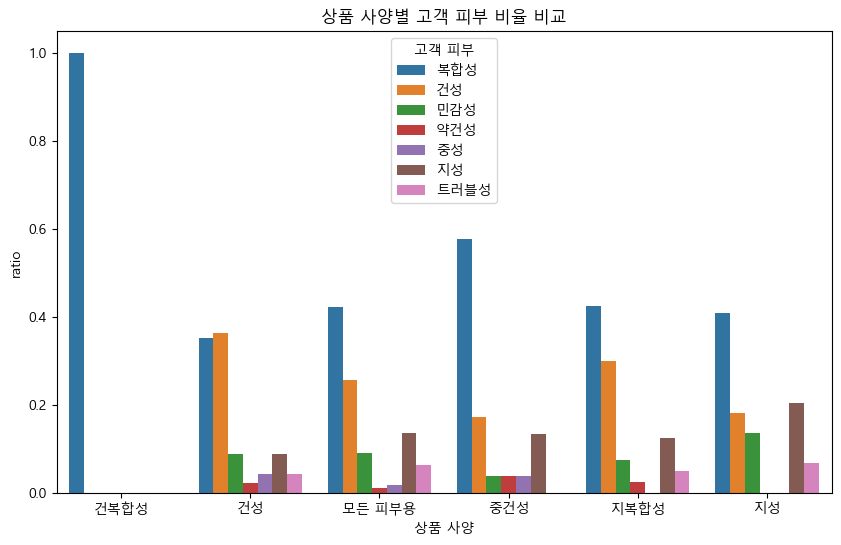

In [12]:
#상품사양별 고객 피부타입 비율
plt.figure(figsize=(10,6))
sns.barplot(x='상품 사양', y='ratio', hue='고객 피부', data=df_ratio)
plt.title("상품 사양별 고객 피부 비율 비교")
plt.show() #복합성은 모든 사양의 상품에서 높은 비율

In [14]:
#type1별 피부타입 사양 평점 barplot
purchase2.평점 = purchase2.평점.astype(float)
df_temp = purchase2.groupby(['피부타입 사양','type1']).agg({'평점':'mean'})
df_temp.reset_index(drop=False, inplace=True)
df_temp.columns = ['상품 사양', '고객 피부', '평점 평균']
df_temp = df_temp[df_temp['평점 평균'] != 5].reset_index(drop=True) #평균이 5점인 경우는 제외
df_temp.head()

,상품 사양,고객 피부,평점 평균
0,건복합성,복합성,4.000000
1,건성,건성,4.636364
2,건성,민감성,4.500000
3,건성,복합성,4.718750
4,건성,지성,4.625000


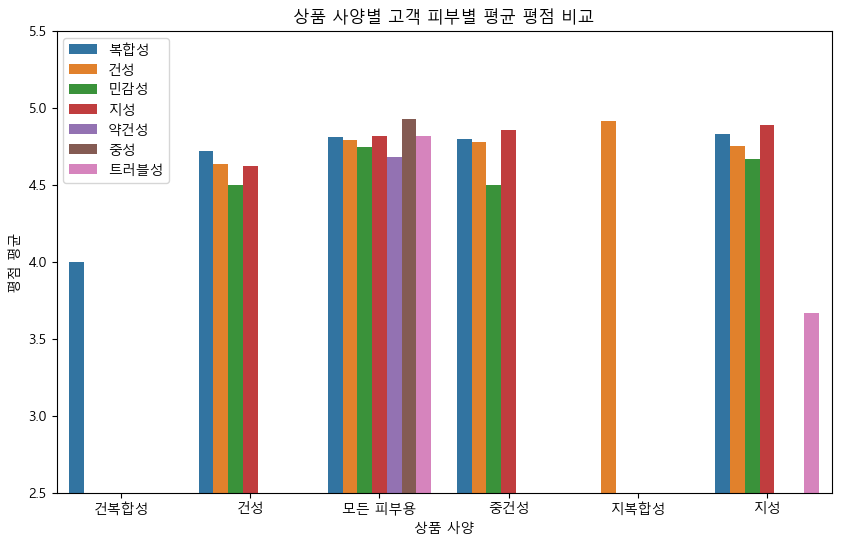

In [15]:
#상품사양별 고객 피부타입 평균 평점
plt.figure(figsize=(10,6))
sns.barplot(x='상품 사양', y='평점 평균', hue='고객 피부', data=df_temp)
plt.title("상품 사양별 고객 피부별 평균 평점 비교")
plt.legend(loc = 'upper left')
plt.ylim(2.5, 5.5)
plt.show() #흠 좀 보기 어렵다

In [75]:
#제품 상세 정보 전처리 : 결측값 처리, 변수 타입 변경
for i in range(1,4):
    product['1_{}피부'.format(i)] = product['1_{}피부'.format(i)].fillna('0%')
    product['1_{}피부'.format(i)] = product['1_{}피부'.format(i)].replace("%","", regex=True)
    product['1_{}피부'.format(i)] = product['1_{}피부'.format(i)].astype(float)

In [77]:
#시각화용 데이터프레임 만들기1
product2 = pd.melt(product, id_vars=['상품명', '피부타입 사양'], value_vars=['1_1피부', '1_2피부', '1_3피부'], value_name='비율', var_name='리뷰')
product2['피부타입 사양'] = product2['피부타입 사양'].fillna('정보 없음')

#건성(1,1)-복합성(1,2)-지성(1,3)
product2['리뷰'] = product2['리뷰'].replace('1_1피부', '건성', regex=True)
product2['리뷰'] = product2['리뷰'].replace('1_2피부', '복합성', regex=True)
product2['리뷰'] = product2['리뷰'].replace('1_3피부', '지성', regex=True)
product2.head()

,상품명,피부타입 사양,리뷰,비율
0,우르오스 스킨로션 200ml,지복합성,건성,16.0
1,우르오스 스킨밀크 200ml,중건성,건성,35.0
2,[대용량] 라운드랩 1025 독도 토너 (본품500ml+100ml 추가 증정),모든 피부용,건성,22.0
3,에스트라 아토베리어365 로션 150ml 기획 (+하이드로에센스 25ml+무기자차선...,모든 피부용,건성,46.0
4,[단독기획] 토리든 다이브인 저분자 히알루론산 토너 300ml 기획(+100ml 추...,모든 피부용,건성,25.0


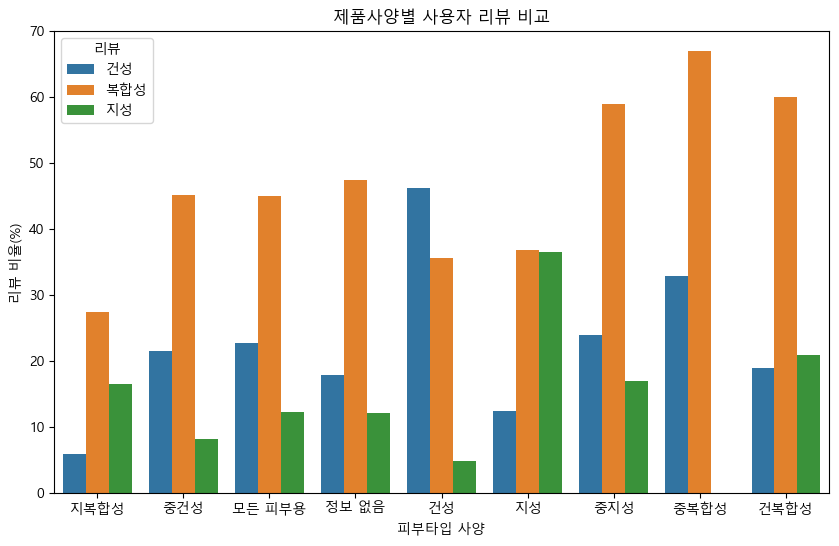

In [78]:
#피부타입 사양별 리뷰 비교
plt.figure(figsize=(10,6))
sns.barplot(x='피부타입 사양', y='비율', hue='리뷰', data=product2, errorbar=None)
plt.title("제품사양별 사용자 리뷰 비교")
plt.ylim(0,70)
plt.ylabel('리뷰 비율(%)')
plt.show() #중지성, 중복합성, 건복합성 상품이 복합성에 good
# 건성과 지성은 사양에 하나만 쓰여있는 경우에 대해 좋게 평가됨